<a href="https://colab.research.google.com/github/patel-zeel/blog/blob/master/_notebooks/GP_Kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Kernels in Gaussian Process
> An exploratory analysis of kernels in GPs

- toc: true 
- badges: true
- comments: true
- author: Zeel Patel
- categories: [ML]


In [ ]:
!pip install -qq GPy
import autograd.numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt
from autograd import grad
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import seaborn as sns

### Basics of kernels in Gaussian processes

Gaussian process (GP) is a stochstic process where each observation is assumed to be a sample from a Gaussian (Normal) distribution. Probability density function (PDF) for a single observation $y_1$ is given as,
$$
\begin{aligned}
y_1 \sim \mathcal{N}\left(\mu_1, \sigma_1^2\right)
\end{aligned}
$$
PDF of multiple such observations is a multivariate Gaussian distribution,
$$
\begin{aligned}
Y \sim \mathcal{N}\left(M, \Sigma\right)
\end{aligned}
$$
In practice, $M$ and $\Sigma$ are modeled as functions of predictors $X$.

Now, multivariate PDF can be modified as,
$$
\begin{aligned}
Y \sim \mathcal{N}\left(\mathcal{F}(X), \mathcal{K}(X,X)\right)
\end{aligned}
$$
Where, $\mathcal{F}$ is a mean function and $\mathcal{K}$ is a kernel (covariance) function. Often $\mathcal{F}(X)$ is assumed to be zero ($\mathcal{F}(X)=0$) and only $\mathcal{K}(X, X)$ is employed to capture relationship between $X$ and $Y$.

The subsequent sections focus on various choices of $\mathcal{K}$ and their effect on $X$ and $Y$.


## RBF (Radial basis function) Kernel, Stationarity and Isotropy

RBF is one of the most commonly used kernels in GPs due to it's infinetely differentiability (extreme flexibility). This property helps us to model a vast variety of functions $X \to Y$.

RBF kernel is given as the following,
$$
\begin{aligned}
\mathcal{K}(x_1,x_2)= \sigma^2exp\left(-\frac{(x-x')^2}{2l^2}\right)
\end{aligned}
$$
Where, $\sigma^2$ is variance and $l$ is known as lengthscale.
#### Stationarity
RBF is a stationary kernel and so it is invariant to translation in the input space. In other words, $\mathcal{K}(x,x')$ depends only on $x-x'$.

#### Isotropy
RBF is also isotropic kernel, which means that $\mathcal{K}(x,x')$ depends only on $|x-x'|$. Thus, we have $\mathcal{K}(x,x') = \mathcal{K}(x',x)$.

Let's visualize few functions drawn from the RBF kernel

In [ ]:
def K_rbf(X1, X2, sigma=1., l=1.):
  return (sigma**2)*(np.exp(-0.5*np.square(X1-X2.T)/l**2))

#### Helper functions

In [ ]:
def plot_functions(kernel_func, ax0_ylim=(-3,3), ax1_ylim=(-0.1,1.1)):
  mean = np.zeros(X.shape[0])
  cov = kernel_func(X, X, sigma, l)
  functions = np.random.multivariate_normal(mean, cov, size=5)
  fig = plt.figure(figsize=(14,8), constrained_layout=True)
  gs = fig.add_gridspec(2,4)
  ax0 = fig.add_subplot(gs[0, 1:-1])
  ax0.set_ylim(*ax0_ylim)
  ax1 = fig.add_subplot(gs[1, 0:2])
  ax1.set_ylim(*ax1_ylim)
  ax2 = fig.add_subplot(gs[1, 2:4])
  for func in functions:
    ax0.plot(X, func,'o-');
  ax0.set_xlabel('X');ax0.set_ylabel('Y');ax0.set_title('Functions drawn from '+k_name+' kernel');
  ax1.plot(X, cov[:,4]);ax1.set_title('K(0,X)');ax1.set_xlabel('X');ax1.set_ylabel('K(0,X)')
  sns.heatmap(cov.round(2), ax=ax2, xticklabels=X.ravel(), yticklabels=X.ravel(), annot=True);
  ax2.set_xlabel('X');ax2.set_ylabel('X');ax2.set_title('Covariance matrix');

def animate_functions(kernel_func, val_list, ax0_ylim=(-3,3), ax1_ylim=(-0.1,1.1), 
                      k_name='',p_name='',symbol=''):
  fig = plt.figure(figsize=(14,8))
  gs = fig.add_gridspec(2,4)
  ax0 = fig.add_subplot(gs[0, 1:-1]);ax1 = fig.add_subplot(gs[1, 0:2]);ax2 = fig.add_subplot(gs[1, 2:4]);
  def update(p):
    ax0.cla();ax1.cla();ax2.cla();
    ax0.set_ylim(*ax0_ylim);ax1.set_ylim(*ax1_ylim)
    if p_name == 'Lengthscale':
      cov = kernel_func(X, X, l=p)
    elif p_name == 'Variance':
      cov = kernel_func(X, X, sigma=np.sqrt(p))
    elif p_name == 'Offset':
      cov = kernel_func(X, X, c=p)
    elif p_name == 'Period':
      cov = kernel_func(X, X, p=p)
    functions = np.random.multivariate_normal(mean, cov, size=5)
    for func in functions:
      ax0.plot(X, func,'o-');
    ax0.set_xlabel('X');ax0.set_ylabel('Y');ax0.set_title('Functions drawn from '+k_name+' kernel\n'+p_name+' ('+symbol+') = '+str(p));
    ax1.plot(X, cov[:,4]);ax1.set_title('K(0,*)');
    sns.heatmap(cov.round(2), ax=ax2, xticklabels=X.ravel(), yticklabels=X.ravel(), annot=True, cbar=False);
    ax2.set_xlabel('X');ax2.set_ylabel('X');ax2.set_title('Covariance matrix');

  anim = FuncAnimation(fig, update, frames=val_list, blit=False)
  plt.close()
  rc('animation', html='jshtml')
  return anim

Verifying if our kernel is consistent with GPy kernels.

In [ ]:
X = np.linspace(101,1001,200).reshape(-1,1)
sigma, l = 7, 11
assert np.allclose(K_rbf(X,X,sigma,l), GPy.kern.RBF(1, variance=sigma**2, lengthscale=l).K(X,X)) 

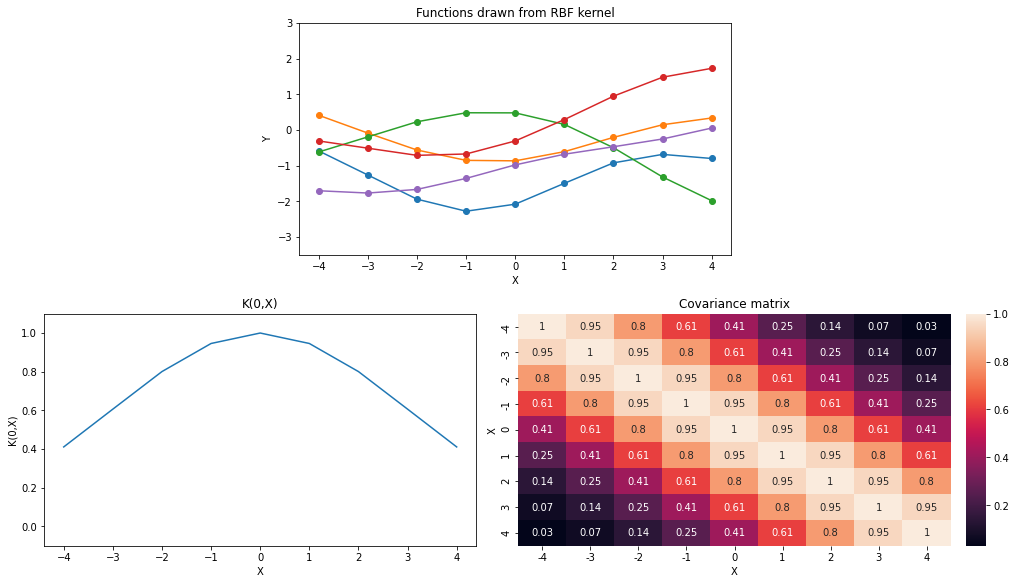

In [ ]:
np.random.seed(0)
X = np.arange(-4,5).reshape(-1,1)
sigma = 1.
l = 3.
k_name = 'RBF'
plot_functions(K_rbf, ax0_ylim=(-3.5,3))

Let's see the effect of varying parameters $\sigma$ and $l$ of the RBF kernel function.

In [ ]:
np.random.seed(0)
sigma = 1.
val_list = [0.5,1,2,3,4,5]
animate_functions(K_rbf, val_list, k_name='RBF', p_name='Lengthscale', symbol='l')

In [ ]:
l = 1.
val_list = [1,4,9,16,25]
animate_functions(K_rbf, val_list, ax0_ylim=(-12,12), ax1_ylim=(-0.1, 26),
                  k_name='RBF', p_name='Variance', symbol='sigma')

With increase in value of $l$, functions drawn from the kernel become smoother. Covariance between a pair of points is increasing with increase in $l$.

Increasing $\sigma^2$ increase the overall uncertainty (width of the space where 95% of the functions live) across all the points.

## Matern Kernel

Matern kernels are given by a general formula as following,
$$
\begin{aligned}
\mathcal{K}(x_1, x_2) =  \sigma^2\frac{1}{\Gamma(\nu)2^{\nu-1}}\Bigg(
\frac{\sqrt{2\nu}}{l} |x_1-x_2|
\Bigg)^\nu K_\nu\Bigg(
\frac{\sqrt{2\nu}}{l} |x_1-x_2|\Bigg)
\end{aligned}
$$
Where, $\Gamma$ is gamma function and $K_\nu$ is modified Bessel function of second order.

The general formula is not very intuitive about the functionality of this kernel. In practice, Matern with $\nu=\{0.5,1.5,2.5\}$ are used, where GP with each kernel is $(\lceil\nu\rceil-1)$ times differentiable.

Matern function corresponding to each $\nu$ value is given as the following,
$$
\begin{aligned}
\mathcal{K_{\nu=0.5}}(x_1, x_2) &=  \sigma^2exp\left(-\frac{|x_1-x_2|}{l}\right)\\
\mathcal{K_{\nu=1.5}}(x_1, x_2) &=  \sigma^2\left(1+\frac{\sqrt{3}|x_1-x_2|}{l}\right)exp\left(-\frac{\sqrt{3}|x_1-x_2|}{l}\right)\\
\mathcal{K_{\nu=2.5}}(x_1, x_2) &=  \sigma^2\left(1+\frac{\sqrt{5}|x_1-x_2|}{l}+\frac{5(x_1-x_2)^2)}{3l^2}\right)exp\left(-\frac{\sqrt{5}|x_1-x_2|}{l}\right)
\end{aligned}
$$
Matern kernel is stationary as well as isotropic. With $\nu \to \infty$ it converges to RBF kernel.

Now, let's draw few functions from each of these versions and try to get intuition behind each of them.

In [ ]:
def K_m12(X1, X2, sigma=1., l=1.): # v = 0.5
  return (sigma**2)*(np.exp(-np.abs(X1-X2.T)/l))
def K_m32(X1, X2, sigma=1., l=1.): # v = 1.5
  return (sigma**2)*(1+((3**0.5)*np.abs(X1-X2.T))/l)*(np.exp(-(3**0.5)*np.abs(X1-X2.T)/l))
def K_m52(X1, X2, sigma=1., l=1.): # v = 2.5
  return (sigma**2)*(1+(((5**0.5)*np.abs(X1-X2.T))/l)+((5*(X1-X2.T)**2)/(3*l**2)))*\
                    (np.exp(-(5**0.5)*np.abs(X1-X2.T)/l))

Verifying if our kernels are consistent with GPy kernels.

In [ ]:
X = np.linspace(101,1001,50).reshape(-1,1)
assert np.allclose(K_m32(X,X,sigma=7.,l=11.), GPy.kern.Matern32(1,lengthscale=11.,variance=7**2).K(X,X))
assert np.allclose(K_m52(X,X,sigma=7.,l=11.), GPy.kern.Matern52(1,lengthscale=11.,variance=7**2).K(X,X))

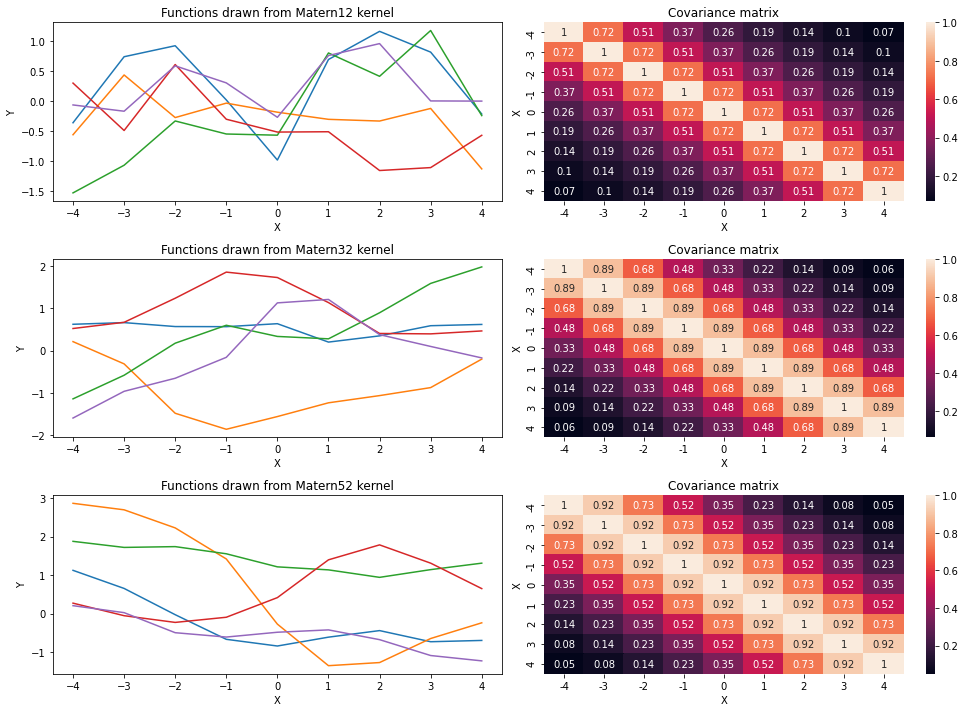

In [ ]:
X = np.arange(-4,5).reshape(-1,1)
sigma = 1.
l = 3.

fig, ax = plt.subplots(3,2,figsize=(14,10))
names = ['Matern12', 'Matern32', 'Matern52']
for k_i, kernel in enumerate([K_m12, K_m32, K_m52]):
  mean = np.zeros(X.shape[0])
  cov = kernel(X, X, sigma, l)
  functions = np.random.multivariate_normal(mean, cov, size=5)
  for func in functions:
    ax[k_i,0].plot(X, func);
  ax[k_i,0].set_xlabel('X');ax[k_i,0].set_ylabel('Y');ax[k_i,0].set_title('Functions drawn from '+names[k_i]+' kernel');
  sns.heatmap(cov.round(2), ax=ax[k_i,1], xticklabels=X.ravel(), yticklabels=X.ravel(), annot=True);
  ax[k_i,1].set_xlabel('X');ax[k_i,1].set_ylabel('X');ax[k_i,1].set_title('Covariance matrix');
plt.tight_layout();

From the above plot, we can say that smoothness is increasing in functions as we increase $\nu$. Thus, smoothness of functions in terms of kernels is in the following order: Matern12<Matern32<Matern52.

Let us see effect of varying $\sigma$ and $l$ on Matern32 which is more popular among the three.

In [ ]:
np.random.seed(0)
sigma = 1.
val_list = [0.5,1,2,3,4,5]
animate_functions(K_m32, val_list, k_name='Matern32', p_name='Lengthscale', symbol='l')

We can see that Matern32 kernel behaves similar to RBF with varying $l$. Though, Matern32 is less smoother than RBF. A quick comparison would clarify this.

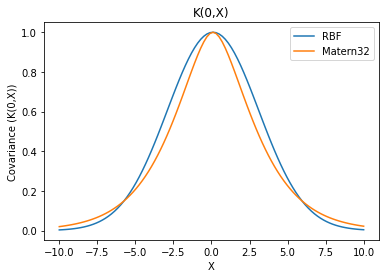

In [ ]:
X = np.linspace(-10,10,100).reshape(-1,1)
plt.plot(X, K_rbf(X,X, l=3.)[:,50], label='RBF')
plt.plot(X, K_m32(X,X, l=3.)[:,50], label='Matern32')
plt.legend();plt.xlabel('X');plt.ylabel('Covariance (K(0,X))');
plt.title('K(0,X)');

## Periodic Kernel

Periodic Kernel is given as the following,
$$
\begin{aligned}
\mathcal{K}(x_1,x_2)= \sigma^2\exp\left(-\frac{\sin^2(\pi|x_1 - x_2|/p)}{2l^2}\right)
\end{aligned}
$$
Where $p$ is period. Let's visualize few functions drawn from this kernel.

In [ ]:
def K_periodic(X1, X2, sigma=1., l=1., p=3.):
  return sigma**2 * np.exp(-0.5*np.square(np.sin(np.pi*(X1-X2.T)/p))/l**2)

X = np.linspace(10,1001,50).reshape(-1,1)
assert np.allclose(K_periodic(X,X,sigma=7.,l=11.,p=3.), 
                   GPy.kern.StdPeriodic(1,lengthscale=11.,variance=7**2,period=3.).K(X,X))

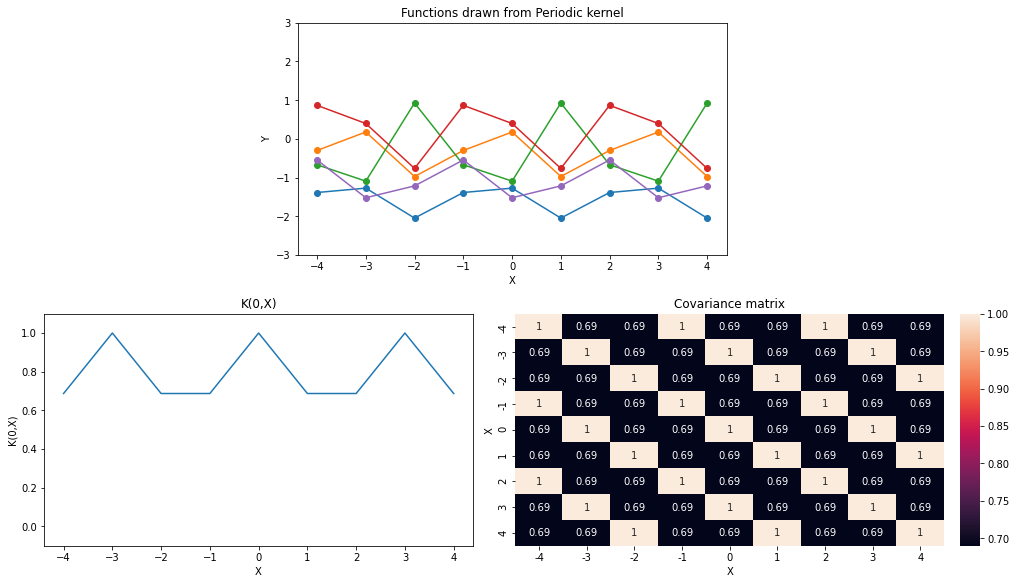

In [ ]:
np.random.seed(0)
X = np.arange(-4,5).reshape(-1,1)
sigma = 1
l = 1.
p = 3.
k_name = 'Periodic'
plot_functions(K_periodic)

We will investigate the effect of varying period $p$ now.

In [ ]:
np.random.seed(0)
val_list = [1., 2., 3., 4., 5.]

animate_functions(K_periodic, val_list, ax1_ylim=(0.4,1.1),
                  k_name='Periodic',p_name='Period')

From the above animation we can see that, all points that are $p$ distance apart from each other have exactly same values because they have correlation of exactly 1 ($\sigma=1 \to covariance=correlation$). 

Now, we will investigate effect of lenging lengthscale $l$ while other parameters are constant.

In [ ]:
np.random.seed(0)
val_list = [1., 2., 3., 4., 5.]

animate_functions(K_periodic, val_list, ax1_ylim=(0.6,1.1),
                  k_name='Periodic',p_name='Lengthscale', symbol='l')

We can see that correlation between a pair of locations $\{x_1,x_2|x_1-x_2<p\}$ increases as the lengthscale is increased.

## Linear Kernel



Linear kernel (a.k.a. dot-product kernel) is given as the following,
$$
\begin{aligned}
\mathcal{K}(x_1,x_2)= (x_1-c)(x_2-c)+\sigma^2
\end{aligned}
$$
Let's visualize few functions drawn from the linear kernel

In [ ]:
def K_lin(X1, X2, sigma=1., c=1.):
  return (X1-c)@(X2.T-c) + sigma**2

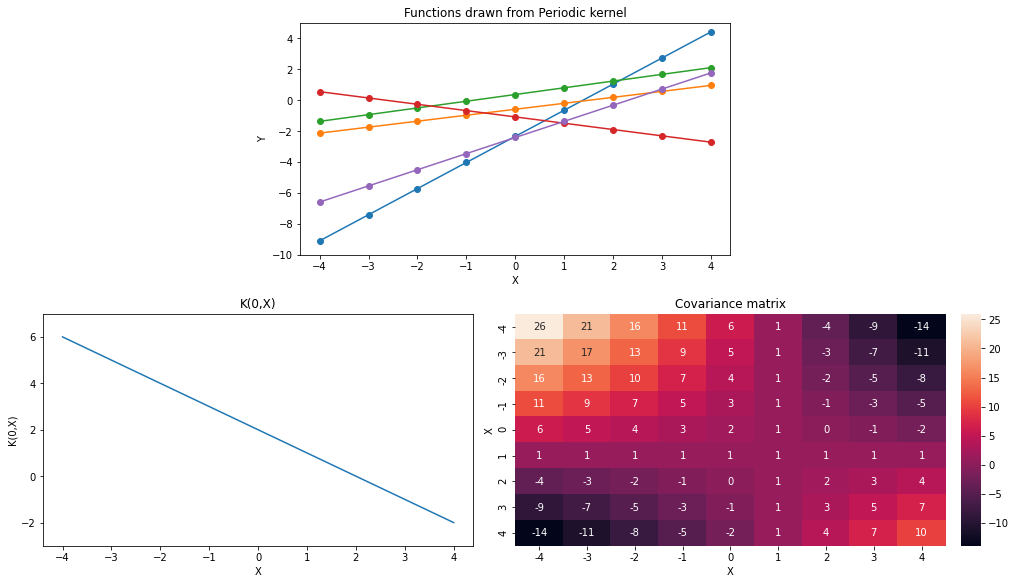

In [ ]:
np.random.seed(0)
sigma = 1.
c = 1.

plot_functions(K_lin, ax0_ylim=(-10,5), ax1_ylim=(-3,7))

Let's see the effect of varying parameters $\sigma$ and $c$ of the linear kernel function.

In [ ]:
val_list = [-3,-2,-1,0,1,2,3]

animate_functions(K_lin, val_list, ax0_ylim=(-15,12), ax1_ylim=(-3,23), 
                  p_name='Offset', symbol='c')

In [ ]:
np.random.seed(1)
val_list = np.square(np.array([1,2,3,4,5,8]))

animate_functions(K_lin, val_list, ax0_ylim=(-25,15), ax1_ylim=(-5,110), 
                  p_name='Variance', symbol='sigma')

Varying $c$ parameter changes position of shallow region in covariance matrix. In other words, as $x \to c$, points close to $x$ have variance $\to \sigma^2$. Distant points have monotonically increasing variance.

Increasing $\sigma^2$ adds a constant in all variance and covariances. So, it allows more uncertainty across all points and weakens the monotonic trend of variance over distant points.

### Non-stationary behaviour of Linear kernel

Unlike other stationary kernels, Linear kernel is not invariant of translations in the input space. The comparison below, visually supports this claim.

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(14,8), sharex=True)
kerns = [K_rbf, K_m32, K_periodic, K_lin]
k_names = ['RBF', 'Matern32', 'Periodic', 'Linear']
X = np.linspace(-10,10,21).reshape(-1,1)
def update(x):
  count = 0
  for i in range(2):
    for j in range(2):
      ax.ravel()[count].cla()
      tmp_kern = kerns[count]
      mean = np.zeros(X.shape[0])
      cov = tmp_kern(X,X)
      ax.ravel()[count].plot(X, cov[:,x]);
      ax.ravel()[count].set_xlim(X[x-3],X[x+3])
      ax.ravel()[count].set_xlabel('X');
      ax.ravel()[count].set_ylabel('K('+str(X[x].round(2))+',X)');
      ax.ravel()[count].set_title('Covariance K('+str(X[x].round(2))+',X) for '+k_names[count]+' kernel');
      count += 1
  ax.ravel()[3].set_ylim(-5,80)
  plt.tight_layout()

anim = FuncAnimation(fig, update, frames=[5,7,9,11,13,15], blit=False)
plt.close()
rc('animation', html='jshtml')
anim

<Figure size 432x288 with 0 Axes>

## Multiplications of kernels

If a single kernel is having high bias in fitting a dataset, we can use mutiple of these kernels in multiplications and/or summations. First, let us see effect of multiplication of a few kernels.

#### Periodic * Linear

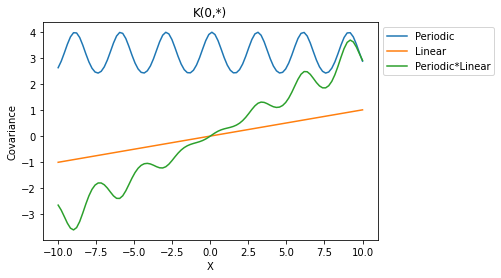

In [ ]:
X = np.linspace(-10,10,100).reshape(-1,1)
plt.plot(X, K_periodic(X,X,sigma=2.)[:,50], label='Periodic')
plt.plot(X, K_lin(X,X,sigma=0.01,c=0)[:,50], label='Linear')
plt.plot(X, K_periodic(X,X,sigma=2.)[:,50]*K_lin(X,X,sigma=0.01,c=0)[:,50], label='Periodic*Linear')
plt.legend(bbox_to_anchor=(1,1));plt.xlabel('X');plt.ylabel('Covariance')
plt.title('K(0,*)');

#### Linear * Linear

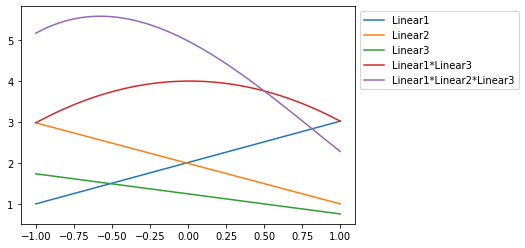

In [ ]:
X = np.linspace(-1,1,100).reshape(-1,1)
plt.plot(X, K_lin(X,X,c=-1)[:,50], label='Linear1')
plt.plot(X, K_lin(X,X,c=1)[:,50], label='Linear2')
plt.plot(X, K_lin(X,X,c=0.5)[:,50], label='Linear3')
plt.plot(X, K_lin(X,X,c=-1)[:,50]*K_lin(X,X,c=1)[:,50], label='Linear1*Linear3')
plt.plot(X, K_lin(X,X,c=-1)[:,50]*K_lin(X,X,c=1)[:,50]*K_lin(X,X,c=0.5)[:,50], label='Linear1*Linear2*Linear3')
plt.legend(bbox_to_anchor=(1,1));

#### Matern * Linear

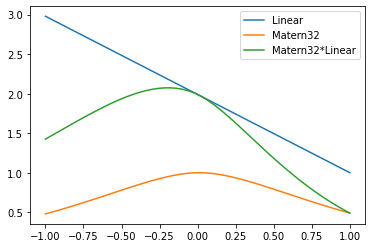

In [ ]:
X = np.linspace(-1,1,100).reshape(-1,1)
k1 = K_lin(X,X,c=1)[:,50]
k2 = K_m32(X,X)[:,50]
plt.plot(X, k1, label='Linear')
plt.plot(X, k2, label='Matern32')
plt.plot(X, k1*k2, label='Matern32*Linear')
plt.legend(bbox_to_anchor=(1,1));

## Appendix (Extra material)

At this stage, we do not know how the fuctions are drawn from linear kernel based covariance matrix end up being lines with various intercepts and slopes.


---


### Predicting at a single point after observing value at a single point

Let's see how would be a GP prediction after observing value at a single point. 

Our kernel function is given by,
* $K(x,x')=(x-c) \cdot (x'-c)+\sigma^2$

Now, we observe value $y$ at a location $x$ and we want to predict value $y^*$ at location $x^*$.
$$
\begin{aligned}
(y^*|x_1,y_1,x^*) &= K(x^*,x) \cdot K^{-1}(x,x)\cdot y \\
&= \left(\frac{(x-c)(x^*-c)+\sigma^2}{(x-c)(x-c)+\sigma^2}\right)\cdot y
\end{aligned}
$$
$c$ and $\sigma^2$ do not vary in numerator and denominator so, the value of $y^* \propto x^*$. 


---




### Predicting at a single point after observing values at two points

Now, we'll take a case where two values ${y_1, y_2}$ are observed at ${x_1, x_2}$. Let us try to predict value $y^*$ at $x^*$.
$$
\begin{align}
y^* &= 
\begin{bmatrix}
K(x_1, x^*) & K(x_2,x^*)
\end{bmatrix}
\begin{bmatrix}
K(x_1, x_1) & K(x_1,x_2) \\
K(x_2, x_1) & K(x_2,x_2)
\end{bmatrix}^{-1}
\begin{bmatrix}
y_1 \\ 
y_2
\end{bmatrix}\\

& =
\begin{bmatrix}
(x_1-c)(x^*-c)+\sigma^2 & (x_2-c)(x^*-c)+\sigma^2
\end{bmatrix}
\begin{bmatrix}
(x_1-c)^2+\sigma^2 & (x_1-c) (x_2-c)+\sigma^2 \\
(x_2-c) (x_1-c)+\sigma^2 & (x_2-c)^2 +\sigma^2
\end{bmatrix}^{-1}
\begin{bmatrix}
y_1 \\ 
y_2
\end{bmatrix} \\


& =
\begin{bmatrix}
(x_1-c)(x^*-c)+\sigma^2 & (x_2-c)(x^*-c)+\sigma^2
\end{bmatrix} \frac{1}{\sigma^2(x_1-x_2)^2}
\begin{bmatrix}
(x_2-c)^2+\sigma^2 & -[(x_1-c)(x_2-c)+\sigma^2] \\
-[(x_2-c) (x_1-c)+\sigma^2] & (x_1-c)^2 +\sigma^2
\end{bmatrix}
\begin{bmatrix}
y_1 \\ 
y_2
\end{bmatrix} \tag{1}
\end{align}
$$

From Eq. (1) second term, we can say that if $\sigma^2=0$, matrix is not-invertible because determinant is zero. It means that, if $\sigma^2=0$, observing a single point is enough, we can infer values at infinite points after observing that single point.  


Evaluating Eq. (1) further, it boils down to the following equation,

\begin{aligned}
y^* = \frac{(x_1y_2-x_2y_1)+x^*(y_1-y_2)}{(x_1-x_2)}
\end{aligned}

Interestingly, we can see that output does not depend on $c$ or $\sigma^2$ anymore. Let us verify experimentally if this is true for observing more than 2 data points.

### Prepering useful functions

In [ ]:
from scipy.optimize import minimize

In [ ]:
def cov_func(x, x_prime, sigma, c):
  return (x-c)@(x_prime-c) + sigma**2

def neg_log_likelihood(params):
  n = X.shape[0]
  sigma, c, noise_std = params
  cov = cov_func(X, X.T, sigma, c)
  cov = cov + (noise_std**2)*np.eye(n)
  nll_ar =  0.5*(Y.T@np.linalg.pinv(cov)@Y) + 0.5*n*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(cov)) 
  return nll_ar[0,0]

def predict(params):
  sigma, c, noise_std = params
  k = cov_func(X, X.T, sigma, c)
  np.fill_diagonal(k, k.diagonal()+noise_std**2)
  k_inv = np.linalg.pinv(k)
  k_star = cov_func(X_test, X.T, sigma, c)

  mean = k_star@k_inv@Y
  cov = cov_func(X_test, X_test.T, sigma, c) - k_star@k_inv@k_star.T
  return mean, cov

### Observing more than two points and changing hyperparameters manually

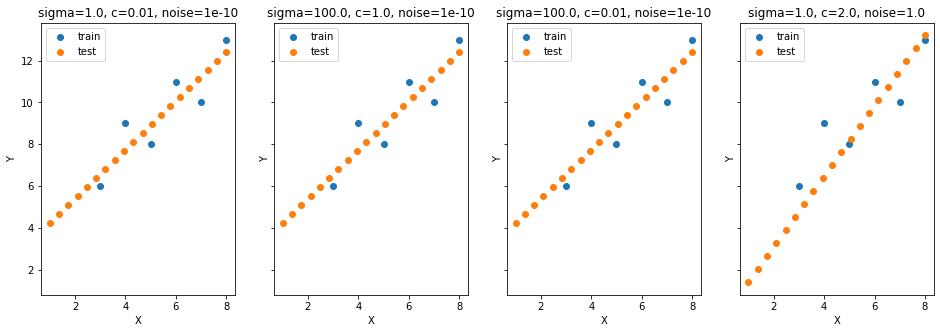

In [ ]:
X = np.array([3,4,5,6,7,8]).reshape(-1,1)
Y = np.array([6,9,8,11,10,13]).reshape(-1,1)
X_test = np.linspace(1,8,20).reshape(-1,1)
params_grid = [[1., 0.01, 10**-10], [100., 1., 10**-10], 
                [100., 0.01, 10**-10], [1., 2., 1.]] # sigma, c, noise_std

X_extra = np.hstack([np.ones((X.shape[0], 1)), X])
Theta = np.linalg.pinv(X_extra.T@X_extra)@X_extra.T@Y
X_test_extra = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
Y_test_ideal = X_test_extra@Theta

fig, ax = plt.subplots(1,4,figsize=(16,5), sharey=True)
means = []
for p_i, params in enumerate(params_grid):
  Y_test_mean, Y_test_cov = predict(params)
  means.append(Y_test_mean)
  ax[p_i].scatter(X, Y, label='train')
  ax[p_i].scatter(X_test, Y_test_mean, label='test')
  ax[p_i].legend();ax[p_i].set_xlabel('X');ax[p_i].set_ylabel('Y');
  ax[p_i].set_title('sigma='+str(params[0])+', c='+str(params[1])+', noise='+str(params[2]));

In [ ]:
np.allclose(Y_test_ideal, means[0]),\
np.allclose(Y_test_ideal, means[1]),\
np.allclose(Y_test_ideal, means[2]),\
np.allclose(Y_test_ideal, means[3])

(True, True, True, False)

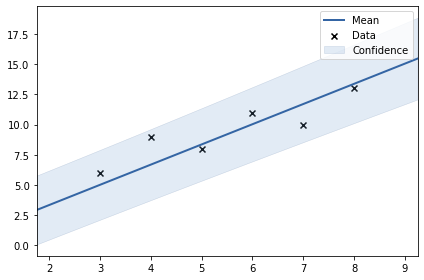

In [ ]:
model = GPy.models.GPRegression(X, Y, GPy.kern.Linear(input_dim=1))
# model['Gaussian_noise'].fix(0.00001)
model.optimize()
model.plot()
model

We can see that there is no change in fit with change in $c$ and $\sigma$. 4th fit is not matching with the ideal fit obtained by normal equation because of high noise. Now, let us estimate parameters by minimizing negative log marginal likelihood. 

[9.99998123e-01 9.99998123e-01 1.00000000e-05] 10207223403405.541


False

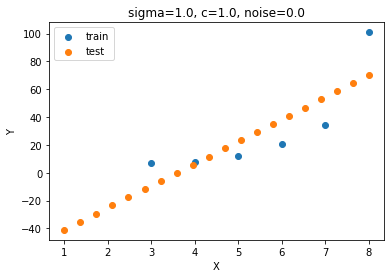

In [ ]:
params = [1., 1., 1.]
result = minimize(neg_log_likelihood, params, bounds=[(10**-5, 10**5), (10**-5, 10**5), (10**-5, 10**-5)])
params = result.x
print(params, result.fun)
Y_test_mean, Y_test_cov = predict(params)
plt.scatter(X, Y, label='train')
plt.scatter(X_test, Y_test_mean, label='test')
plt.legend();plt.xlabel('X');plt.ylabel('Y');
params = np.round(params, 4)
plt.title('sigma='+str(params[0])+', c='+str(params[1])+', noise='+str(params[2]));
np.allclose(Y_test_ideal, Y_test_mean)

In [ ]:
def neg_log_likelihood(sigma, c, noise_std):
  n = X.shape[0]
  cov = cov_func(X, X.T, sigma, c)
  cov = cov + (noise_std**2)*np.eye(n)
  nll_ar =  0.5*(Y.T@np.linalg.pinv(cov)@Y) + 0.5*n*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(cov))
  return nll_ar[0,0]

7.588989986845149 -2.830840439162303 32.2487569348891


31.05187173290998

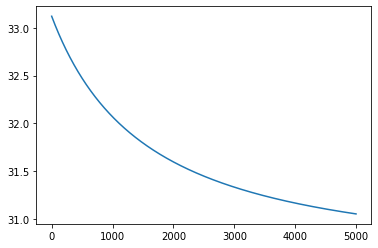

In [ ]:
grad_func = grad(neg_log_likelihood, argnum=[0,1,2])
alpha = 0.01
loss = []
sigma, c, noise_std = 1., 1., 1.
for _ in range(5000):
  grads = grad_func(sigma, c, noise_std)
  # print(grads)
  sigma = sigma - alpha*grads[0]
  c = c - alpha*grads[1]
  noise_std = noise_std - alpha*grads[2]
  loss.append(neg_log_likelihood(sigma, c, noise_std))
print(sigma, c, noise_std)
plt.plot(loss);
loss[-1]

False

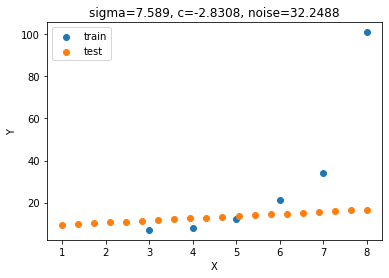

In [ ]:
params = sigma, c, noise_std
Y_test_mean, Y_test_cov = predict(params)
plt.scatter(X, Y, label='train')
plt.scatter(X_test, Y_test_mean, label='test')
plt.legend();plt.xlabel('X');plt.ylabel('Y');
params = np.round(params, 4)
plt.title('sigma='+str(params[0])+', c='+str(params[1])+', noise='+str(params[2]));
np.allclose(means[0], Y_test_mean, rtol=10**-1, atol=10**-1)